# Importing all required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import pydotplus

# Reading Data

In [2]:
x_train = np.genfromtxt('x_train.csv', delimiter = ',')[1:, 1:]
x_validate = np.genfromtxt('x_validate.csv', delimiter = ',')[1:, 1:]
x_test = np.genfromtxt('x_test.csv', delimiter = ',')[1:, 1:]

In [3]:
y_train = np.genfromtxt('y_train.csv', delimiter = ',')[1:, 1:]
y_train = y_train.reshape(y_train.shape[0])

y_test = np.genfromtxt('y_test.csv', delimiter = ',')[1:, 1:]
y_test = y_test.reshape(y_test.shape[0])

y_validate = np.genfromtxt('y_validate.csv', delimiter = ',')[1:, 1:]
y_validate = y_validate.reshape(y_validate.shape[0])

# BaseLine Model

In [47]:
clf1 = DecisionTreeClassifier(random_state = 0)
clf1.fit(x_train, y_train)
y_pred_test = clf1.predict(x_test)
y_pred_train = clf1.predict(x_train)
print("Accuracy of Test Data : ", accuracy_score(y_test, y_pred_test), "Accuracy of Train_Data : " 
      , accuracy_score(y_train, y_pred_train))

Accuracy of Test Data :  0.9196022727272727 Accuracy of Train_Data :  1.0


In [48]:
# visualizing the tree
dot_data1 = export_graphviz(clf1, out_file = None, feature_names = [('col ' + str(i)) for i in range(42)], 
                            class_names = [str(i) for i in range(1, 9)]) 
graph1 = pydotplus.graph_from_dot_data(dot_data1)
graph1.write_pdf('BaseLine_DecisionTree.pdf')

True

In [49]:
# here looking at the accuracy of training and testing data it seems that classifier is overfitting the data

## Parameter Tuning

In [50]:
def param_tuning(x_train, x_validate, y_train, y_validate):
    criterion = ["gini", "entropy"]
    max_depth = [27, 28, 29, 30, 31, 32]
    max_leaf_nodes = [475, 500, 525, 550, 575]
    max_acc = 0
    c_max = ""
    d_max = 0
    l_max = 0
    for c in criterion:
        for d in max_depth:
            for l in max_leaf_nodes:
                clf = DecisionTreeClassifier(criterion = c, max_depth = d, random_state = 0, max_leaf_nodes = l)
                clf.fit(x_train, y_train)
                y_val_pred = clf.predict(x_validate)
                if (accuracy_score(y_validate, y_val_pred) > max_acc):
                    max_acc = accuracy_score(y_validate, y_val_pred)
                    c_max = c
                    d_max = d
                    l_max = l
    return c_max, d_max, l_max

In [51]:
c_optimal, d_optimal, l_optimal = param_tuning(x_train, x_validate, y_train, y_validate)

In [52]:
print("optimal criterion :", c_optimal,"\noptimal max_depth :", d_optimal,"\noptimal max_leaf_nodes :", l_optimal)

optimal criterion : gini 
optimal max_depth : 30 
optimal max_leaf_nodes : 475


In [53]:
clf2 = DecisionTreeClassifier(criterion = c_optimal, max_depth = d_optimal, random_state = 0, max_leaf_nodes = l_optimal)
clf2.fit(x_train, y_train)
y_pred_test = clf2.predict(x_test)
y_pred_train = clf2.predict(x_train)

In [54]:
# visualizing the tree
dot_data1 = export_graphviz(clf2, out_file = None, feature_names = [('col ' + str(i)) for i in range(42)], 
                            class_names = [str(i) for i in range(1, 9)]) 
graph1 = pydotplus.graph_from_dot_data(dot_data1)
graph1.write_pdf('Tuned_DecisionTree.pdf')

True

In [55]:
print("Classification Report : ", classification_report(y_test, y_pred_test))

Classification Report :                precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       879
         2.0       0.96      0.97      0.96       888
         3.0       0.94      0.93      0.94       878
         4.0       0.80      0.82      0.81       897
         5.0       0.97      0.97      0.97       874
         6.0       0.89      0.88      0.88       883
         7.0       0.84      0.83      0.83       898
         8.0       0.99      0.99      0.99       843

    accuracy                           0.92      7040
   macro avg       0.92      0.92      0.92      7040
weighted avg       0.92      0.92      0.92      7040



In [56]:
print("Accuracy of Test Data : ", accuracy_score(y_test, y_pred_test), "Accuracy of Train_Data : " 
      , accuracy_score(y_train, y_pred_train))

Accuracy of Test Data :  0.9211647727272727 Accuracy of Train_Data :  0.9967131877022654


Text(114.0, 0.5, 'Actual Class')

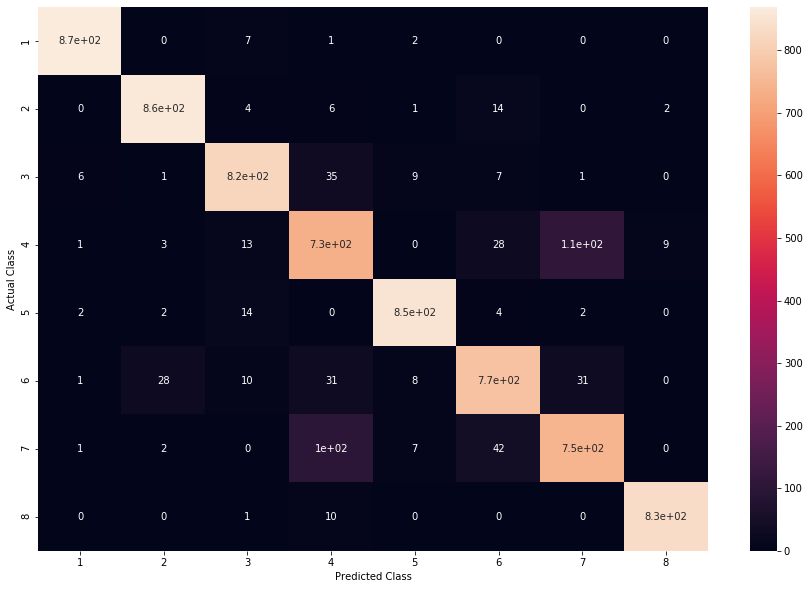

In [57]:
conf_mat = confusion_matrix(y_test, y_pred_test)
# visualization of the predicted class vs actual class (0 based indexing)
plt.figure(figsize = (15, 10))
classes = [i for i in range(1, 9)]
svm_df = pd.DataFrame(conf_mat, index = classes, columns = classes)
sns.heatmap(svm_df, annot = True)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

In [58]:
# After parameter tuning ... that is fixing max_depth and leaf nodes accuracy is somewhat improved

# Pruning

In [6]:
clf3 = DecisionTreeClassifier(random_state = 0)
path = clf3.cost_complexity_pruning_path(x_train, y_train) 
ccp_alphas, impurities = path.ccp_alphas, path.impurities

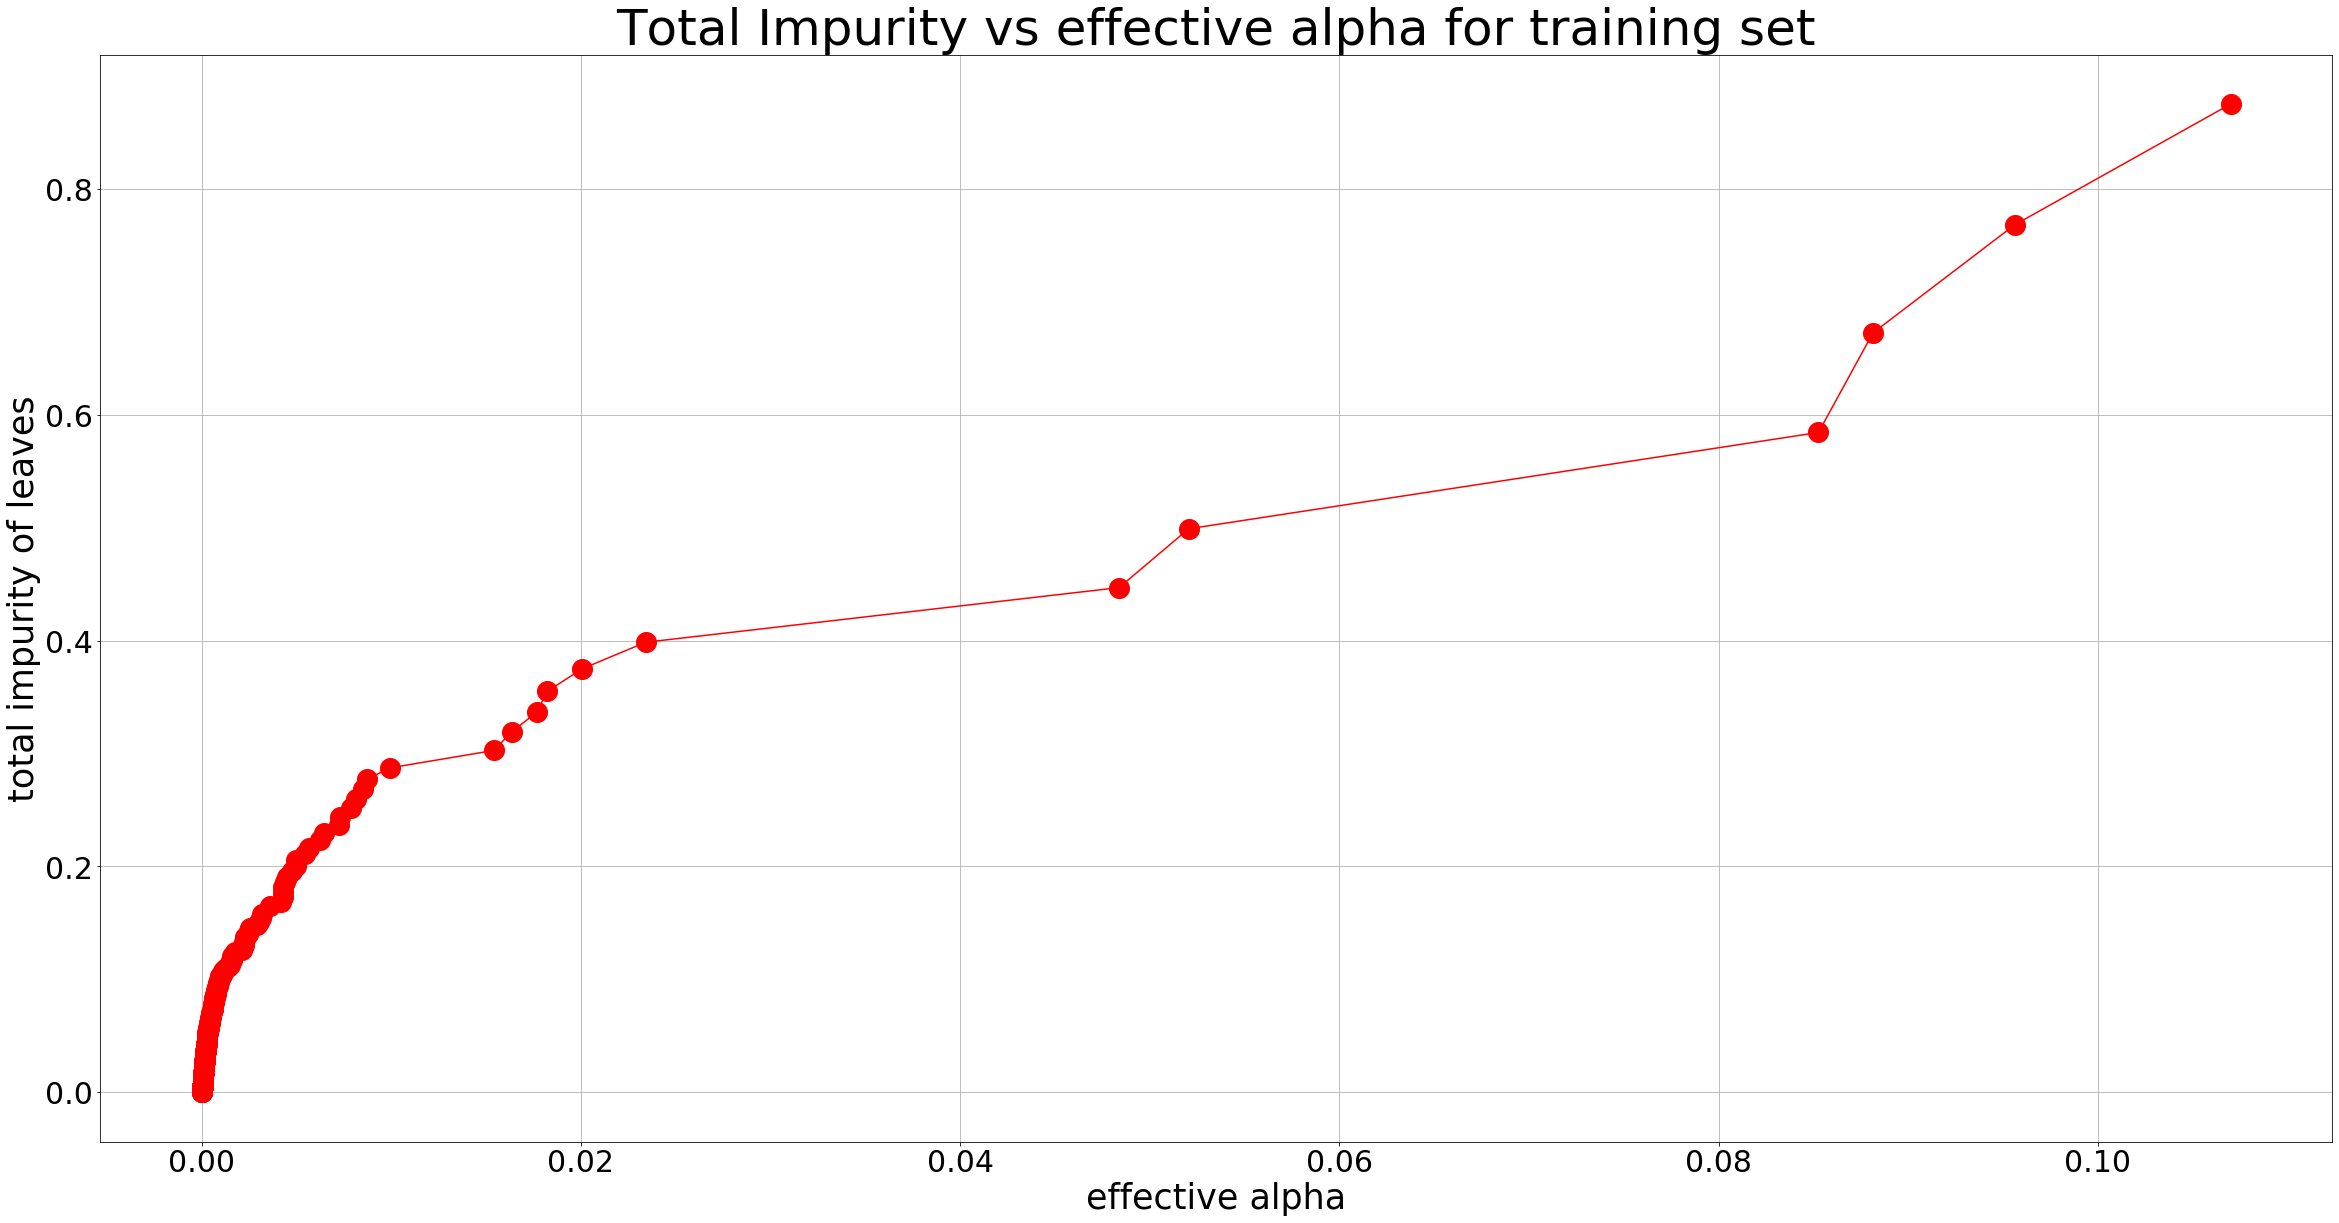

In [7]:
fig, ax = plt.subplots(figsize = (40, 20))
ax.plot(ccp_alphas, impurities, marker='o', color = 'red', markersize = 20)
ax.set_xlabel("effective alpha", fontsize = 35)
ax.set_ylabel("total impurity of leaves", fontsize = 35)
plt.xticks(size = 30)
plt.yticks(size = 30)
ax.set_title("Total Impurity vs effective alpha for training set", fontsize = 50)
plt.grid()
plt.show()

## Accuracy Vs Effective Alpha

In [8]:
def pruning(ccp_alphas, x_train, y_train, x_validate, y_validate):
    # defining required data structures
    validate_accuracy_list = list()
    train_accuracy_list = list()
    max_acc = 0
    optimal_ccp = 0
    
    for ccp_alpha in ccp_alphas:
        # fitting classifier
        clf = DecisionTreeClassifier(random_state = 0, ccp_alpha = ccp_alpha)
        clf.fit(x_train, y_train)
        # predicted classes
        y_val_pred = clf.predict(x_validate)
        y_train_pred = clf.predict(x_train)
        # calculating accuracy for train and validate dataset
        acc = accuracy_score(y_validate, y_val_pred)
        validate_accuracy_list.append(acc)
        train_accuracy_list.append(accuracy_score(y_train, y_train_pred))
        
        if acc > max_acc:
            max_acc = acc
            optimal_ccp = ccp_alpha
            
    return validate_accuracy_list, train_accuracy_list,optimal_ccp

In [9]:
validate_accuracy_list, train_accuracy_list, optimal_ccp_alpha = pruning(ccp_alphas, x_train, y_train, x_validate, y_validate)
print("Optimal CCP : " , optimal_ccp_alpha)

Optimal CCP :  0.00017114762260393327


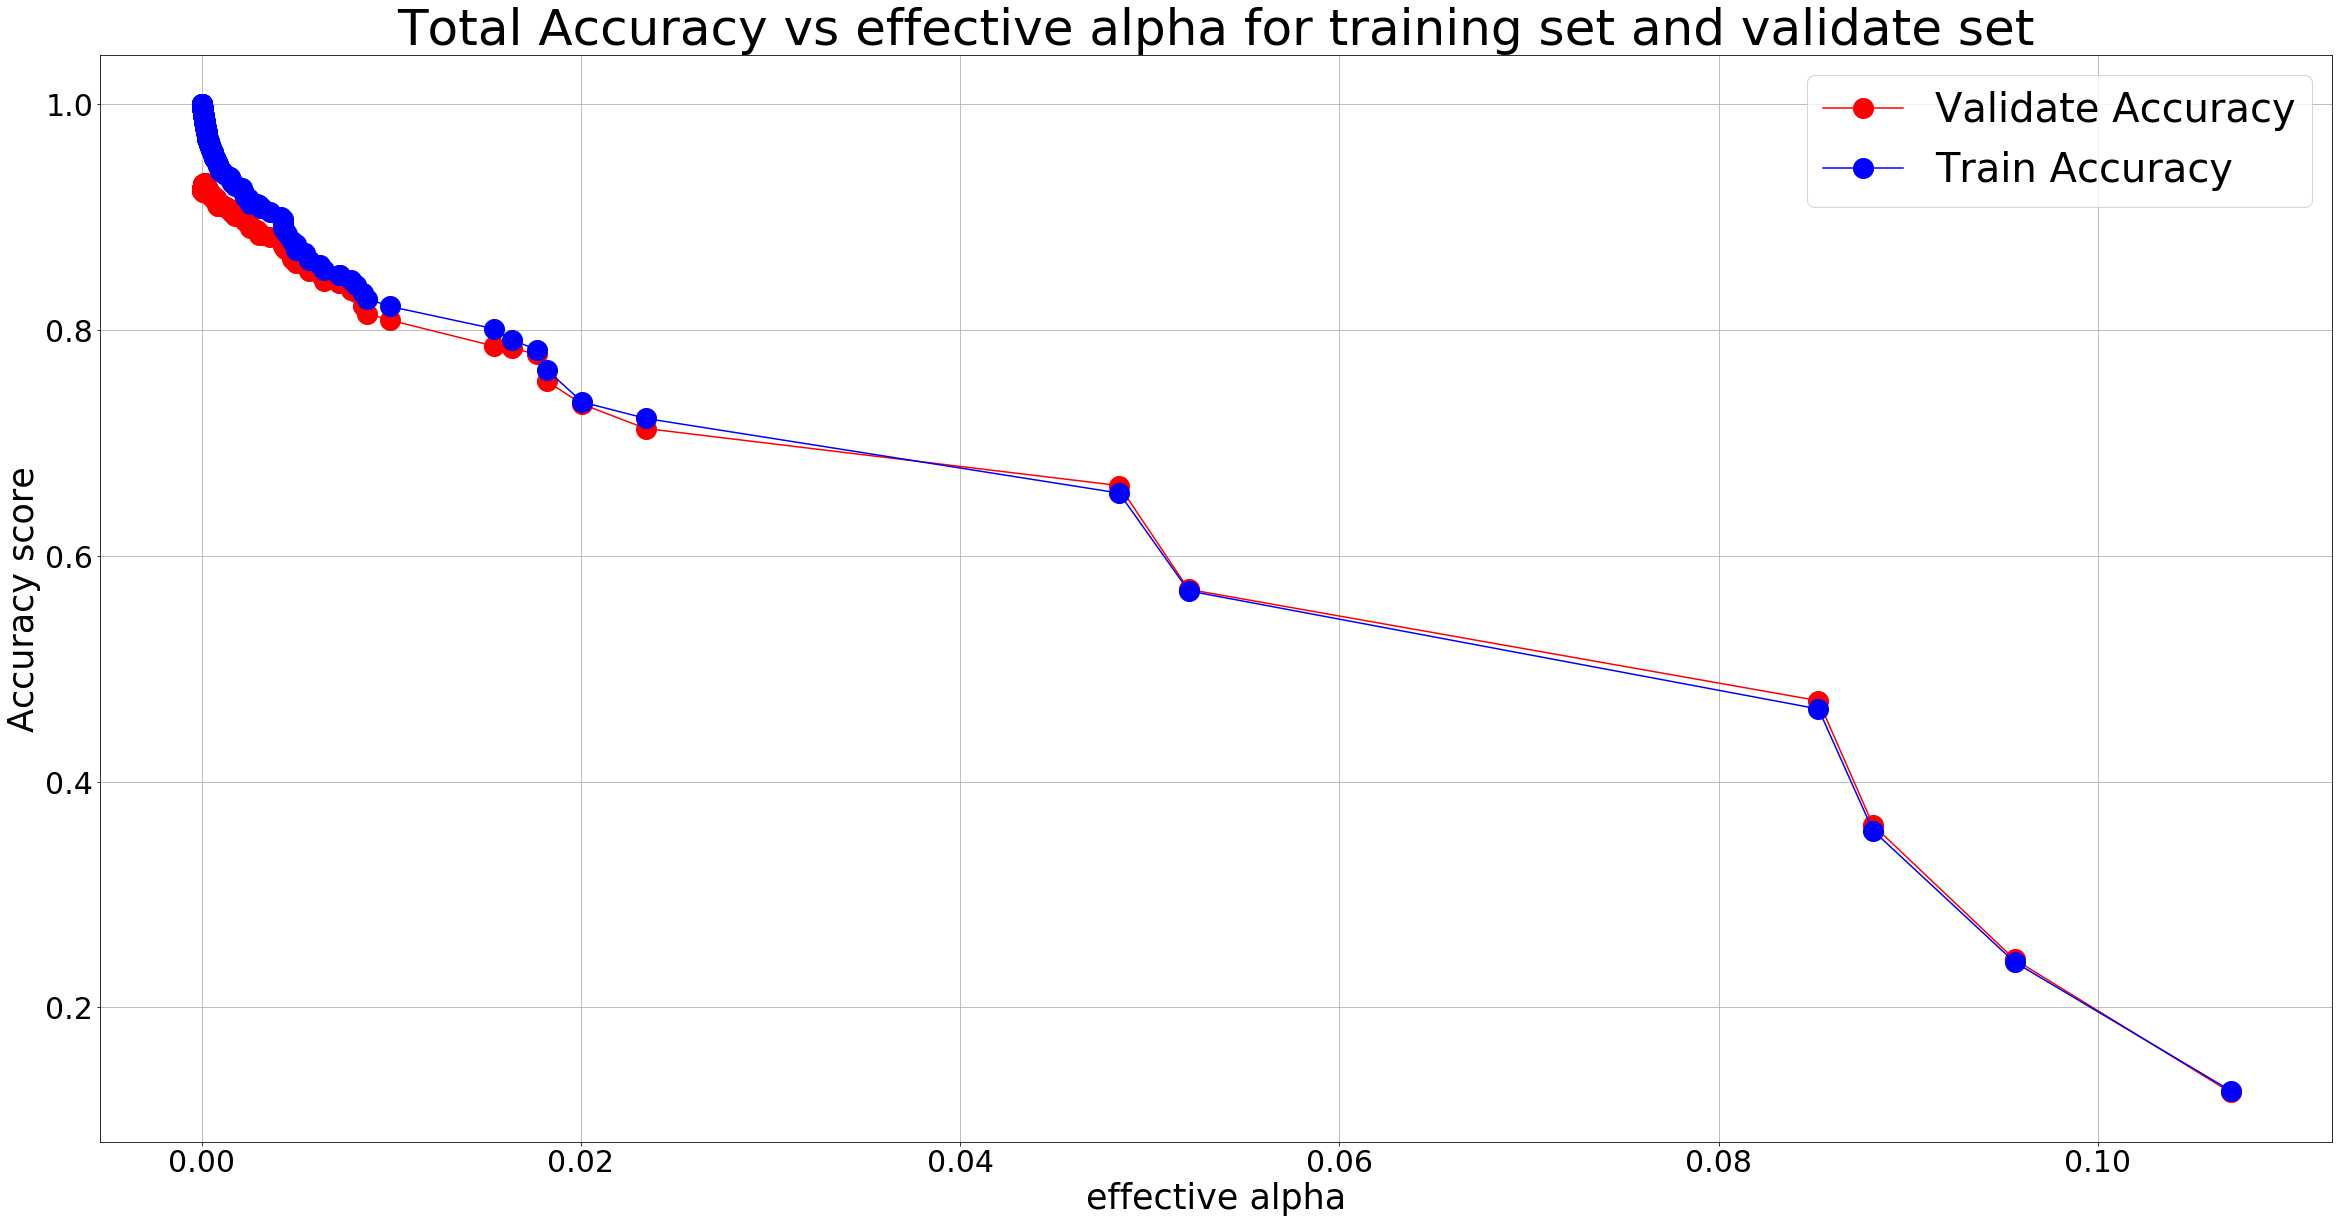

In [10]:
fig, ax = plt.subplots(figsize = (40, 20))
ax.plot(ccp_alphas, validate_accuracy_list, marker='o', color = 'red', markersize = 20, label = "Validate Accuracy")
ax.plot(ccp_alphas, train_accuracy_list, marker='o', color = 'blue', markersize = 20, label = "Train Accuracy")
ax.set_xlabel("effective alpha", fontsize = 35)
ax.set_ylabel("Accuracy score", fontsize = 35)
plt.xticks(size = 30)
plt.yticks(size = 30)
ax.set_title("Total Accuracy vs effective alpha for training set and validate set", fontsize = 50)
ax.legend(prop = {'size' : 40})
plt.grid()
plt.show()

In [13]:
Clf = DecisionTreeClassifier(ccp_alpha = optimal_ccp_alpha)
Clf.fit(x_train, y_train)
y_pred = Clf.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred)
print("Classification Report : \n", classification_report(y_test, y_pred))
print('\n\nAccuracy Score : ', accuracy_score(y_test, y_pred))
print('\n\nConfusion Matrix : \n', confusion_matrix(y_test, y_pred))

Classification Report : 
               precision    recall  f1-score   support

         1.0       0.99      0.99      0.99       879
         2.0       0.96      0.97      0.96       888
         3.0       0.94      0.97      0.95       878
         4.0       0.84      0.84      0.84       897
         5.0       0.97      0.97      0.97       874
         6.0       0.89      0.87      0.88       883
         7.0       0.84      0.85      0.85       898
         8.0       0.99      0.97      0.98       843

    accuracy                           0.93      7040
   macro avg       0.93      0.93      0.93      7040
weighted avg       0.93      0.93      0.93      7040



Accuracy Score :  0.9274147727272727


Confusion Matrix : 
 [[868   0   8   0   3   0   0   0]
 [  0 862   3   5   1  14   3   0]
 [  8   1 849   1  10   9   0   0]
 [  0   1  12 752   0  23 104   5]
 [  1   1  13   0 850   8   1   0]
 [  0  28  12  34   5 770  34   0]
 [  0   1   0  85   7  43 762   0]
 [  0   7   4  1

In [15]:
# visualizing the tree
dot_data1 = export_graphviz(Clf, out_file = None, feature_names = [('col ' + str(i)) for i in range(42)], 
                            class_names = [str(i) for i in range(1, 9)]) 
graph1 = pydotplus.graph_from_dot_data(dot_data1)
graph1.write_pdf('Pruned_DecisionTree.pdf')

True

Text(114.0, 0.5, 'Actual Class')

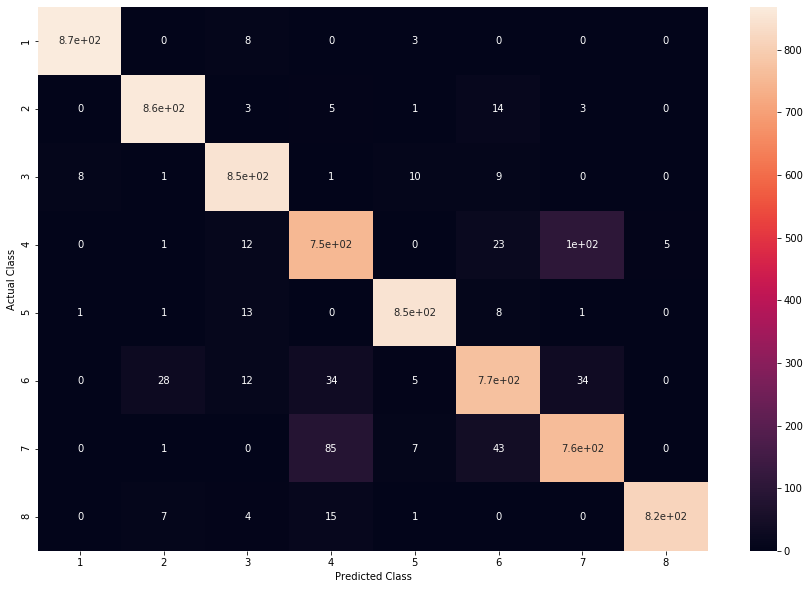

In [16]:
# visualization of the predicted class vs actual class (0 based indexing)
plt.figure(figsize = (15, 10))
classes = [i for i in range(1, 9)]
svm_df = pd.DataFrame(conf_mat, index = classes, columns = classes)
sns.heatmap(svm_df, annot = True)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

In [17]:
# Accuracy score = 0.93